# Get t events
Convert indicator to t events

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)
ind = pd.read_csv("../data/vol.csv", index_col=0, parse_dates=True, squeeze=True)

In [3]:
# df = df[-100_000:]

In [10]:
def get_t_events(g_raw, h, m):
    """
    Implementation of the symmetric CUSUM filter seen in chapter 2.5.2
    
    Arguments:
    g_raw -- the raw time series to filter (possibly pandas series)
    h -- threshold pandas series vol
    m -- minimum threshold (float, ex: 0.02)
    
    Purpose:
    The CUSUM filter is a quality-control method, designed to detect a shift in the mean value of a measured quantity away from a target value. 
    """
    h = h.map(lambda x: x if x>=m else m)
    t_events, s_pos, s_neg = [], 0, 0
    side = []
    diff = np.log(g_raw).diff().dropna()
    for i in diff.index[1:]:
        try:
            pos, neg = float(s_pos+diff.loc[i]), float(s_neg+diff.loc[i])
        except Exception as e:
            print(e)
            print(s_pos+diff.loc[i], type(s_pos+diff.loc[i]))
            print(s_neg+diff.loc[i], type(s_neg+diff.loc[i]))
            break

        
        s_pos, s_neg=max(0., pos), min(0., neg)
        
        
        try: 
            th = h.loc[i]
        except:
            try:
                th = h[h.index.get_loc(i, method="pad")]
            except: #i is before the first ever h
                continue

        if s_neg<-th:
            s_neg=0
            t_events.append(i)
            side.append(0)
        if s_pos>th:
            s_pos=0
            t_events.append(i)
            side.append(1)
        
    return pd.DatetimeIndex(t_events), side

In [5]:
print(f"max: {max(ind[1:].dropna())}")
print(f"min: {min(ind[1:].dropna())}")
print(f"mean: {np.mean(ind)}")
print(f"median: {np.median(ind[1:].dropna())}")

max: 0.1567727171053577
min: 0.0036702801383765
mean: 0.02651504315228308
median: 0.02281254582903505


In [11]:
t_events, side = get_t_events(df.close,h=ind, m=0.015)
t_events

DatetimeIndex(['2017-08-19 04:25:59.354000', '2017-08-19 04:25:59.354000',
               '2017-08-19 05:16:47.885000', '2017-08-19 05:31:30.438000',
               '2017-08-19 07:07:00.089000', '2017-08-19 07:56:46.636000',
               '2017-08-19 11:19:51.101000', '2017-08-19 11:41:47.268000',
               '2017-08-19 12:26:06.946000', '2017-08-19 15:50:47.487000',
               ...
               '2021-06-19 01:11:49.768000', '2021-06-19 02:33:21.277000',
               '2021-06-19 03:27:09.944000', '2021-06-19 04:30:08.711000',
               '2021-06-19 06:00:23.589000', '2021-06-19 11:31:42.178000',
               '2021-06-19 12:15:48.165000', '2021-06-19 12:45:36.357000',
               '2021-06-19 14:30:16.120000', '2021-06-19 16:20:11.162000'],
              dtype='datetime64[ns]', length=7135, freq=None)

In [12]:
target = df.close.reindex(t_events).diff().shift(-1).map(lambda x: 1 if x>0 else 0)
target

2017-08-19 04:25:59.354    0
2017-08-19 04:25:59.354    1
2017-08-19 05:16:47.885    0
2017-08-19 05:31:30.438    0
2017-08-19 07:07:00.089    1
                          ..
2021-06-19 11:31:42.178    1
2021-06-19 12:15:48.165    0
2021-06-19 12:45:36.357    1
2021-06-19 14:30:16.120    0
2021-06-19 16:20:11.162    0
Name: close, Length: 7135, dtype: int64

In [19]:
side = pd.Series(side, index=t_events)
side

2017-08-19 04:25:59.354    0
2017-08-19 04:25:59.354    1
2017-08-19 05:16:47.885    1
2017-08-19 05:31:30.438    0
2017-08-19 07:07:00.089    0
                          ..
2021-06-19 11:31:42.178    1
2021-06-19 12:15:48.165    1
2021-06-19 12:45:36.357    0
2021-06-19 14:30:16.120    1
2021-06-19 16:20:11.162    0
Length: 7135, dtype: int64

In [21]:
target.to_csv("../data/target-original.csv")
side.to_csv("../data/side-original.csv")

## Plotting

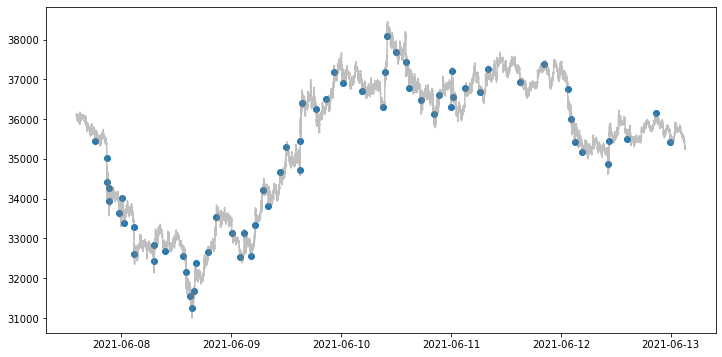

In [74]:
a = -200000
b = -100000
test = df[a:b].reindex(t_events)
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.close[a:b], color="gray", alpha=.5)
ax.scatter(test.index, test.close)

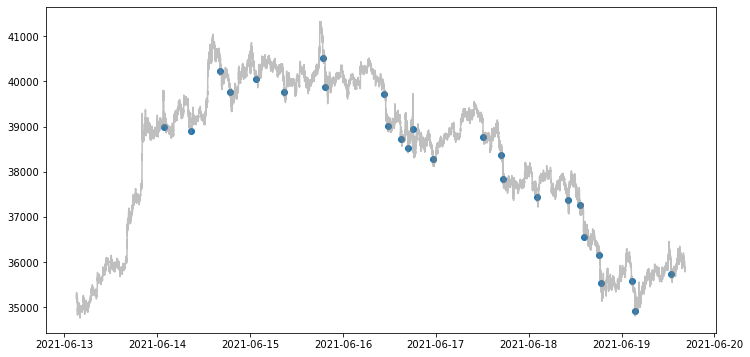

In [51]:
a = None
b = None
test = df[a:b].reindex(t_events)
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.close[a:b], color="gray", alpha=.5)
ax.scatter(test.index, test.close)